In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/BI/data/bikeshare_data.csv')

In [3]:
data.shape

(17379, 13)

## 預覽

In [ ]:
# data.shape

In [ ]:
# data.head(3)

## 預處理

humidity

In [ ]:
data['humidity'].replace({'x61':'61'},inplace=True)
data['humidity'] = data['humidity'].astype('int')

sources

In [ ]:
# sources = pd.DataFrame(data['sources'].value_counts())
# sources.reset_index(level=0, inplace=True)
# sources0 = sources.rename(columns={'index':'type','sources':'counts'})
# sources0

## 缺值

sources 少了 554 項 (3.2%)

In [ ]:
isna = data.isna()
col = list(data.columns)

In [ ]:
# for i in range(len(col)):
#   print(isna[col[i]].value_counts())

In [ ]:
# data.dropna(subset = ['sources'], inplace=True)
data['sources'] = data['sources'].fillna('ad campaign')

整理＋歸類

In [ ]:
data['sources'].replace({'AD campaign':'ad campaign','Ad Campaign':'ad campaign'},inplace=True)
data['sources'].replace({'Twitter    ':'Twitter'},inplace=True)
data['sources'].replace({'www.google.fi':'google','www.google.com':'google','www.google.co.uk':'google'},inplace=True)
data['sources'].replace({'www.yahoo.com':'yahoo'},inplace=True)
data['sources'].replace({'www.bing.com':'bing'},inplace=True)
data['sources'].replace({'facebook page':'FB'},inplace=True)

pie chart

In [ ]:
# import plotly.express  as px
# import plotly.graph_objects as go
# temp_df = pd.DataFrame(data['sources'].value_counts()).reset_index()

# fig = go.Figure(data=[go.Pie(labels=temp_df['index'],
#                values=temp_df['sources'],
#                         hole=.7,
#             title = '% of sources',
#          marker_colors = px.colors.sequential.Blues_r,
#                             )
                     
#                      ])
# fig.update_layout(title='sources')
# fig.show()

In [ ]:
# sources = pd.DataFrame(data['sources'].value_counts())
# sources.reset_index(level=0, inplace=True)
# sources1 = sources.rename(columns={'index':'type','sources':'counts'})
# sources1

sources turn dummy >>> concat

In [ ]:
sources = pd.get_dummies(data['sources'])
data = pd.concat([data,sources], axis=1)

In [ ]:
data = data.drop('datetime',axis=1)
data = data.drop('sources',axis=1)

In [ ]:
data.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'FB',
       'Twitter', 'ad campaign', 'bing', 'blog', 'direct', 'google', 'yahoo'],
      dtype='object')

In [ ]:
# data.dtypes

In [ ]:
data = data.drop('registered',axis=1)

In [ ]:
# cor=pd.DataFrame(data.corr())
# cor['count']
# cor['temp']
# cor['atemp']

In [ ]:
# pd.DataFrame(data.iloc[:,12:].corr())

In [ ]:
# data.head(2)

## label移動位置

In [ ]:
data['counts'] = data['count'] #移到最右邊 
data = data.drop('count',axis=1)

## VIF

In [ ]:
data = data.drop('atemp',axis=1)
data = data.drop('ad campaign',axis=1)
# data = data.drop('blog',axis=1)
# data = data.drop('yahoo',axis=1)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(data.iloc[:,:-1])
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)

const         34.968909
season         1.164306
holiday        1.073320
workingday     1.290049
weather        1.265540
temp           1.530817
humidity       1.624507
windspeed      1.136497
casual         1.834909
FB             1.155997
Twitter        1.172326
bing           1.159519
blog           1.055262
direct         1.161339
google         1.252817
yahoo          1.169142
dtype: float64

## ACF

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



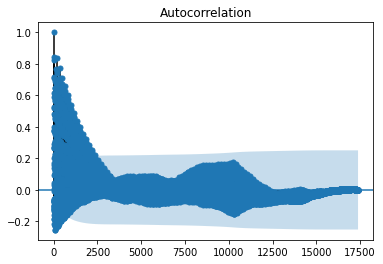

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

sm.tsa.acf(data['counts'])
fig = tsaplots.plot_acf(data['counts'], lags=len(data['counts'])-1)
# fig = tsaplots.plot_acf(data['counts'], lags=100)
plt.show()

## test/train split

0.8 / 0.2 >>> 13903 / 3476

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size =0.2, random_state=1)

## 直接做

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.5633906507825465

score

## PCA

In [ ]:
# data.shape

In [ ]:
# data.head(3)

In [ ]:
# X_train.shape

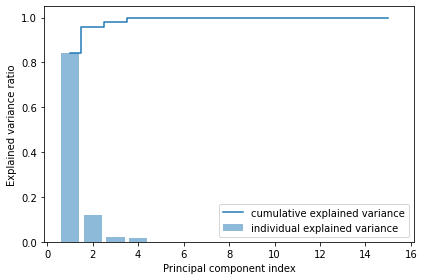

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train)
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)
plt.bar(range(1,16),var_ratio,alpha=0.5,align='center',label='individual explained variance')
plt.step(range(1,16),cum_var_ratio,where='mid',label='cumulative explained variance')
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

train data >>> build model

In [ ]:
from sklearn.decomposition import PCA

PCA_model_list=[]
for i in range(1,16):
  model = PCA(n_components=i).fit_transform(X_train)
  PCA_model_list.append(model)
  
PCA_test=[]
for j in range(1,16):
  t = PCA(n_components=j).fit_transform(X_test)
  PCA_test.append(t)

In [ ]:
# PCA_test[0]

## linear regression

model

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg_model_list=[]
for i in range(15):
  X = PCA_model_list[i]
  reg_model_list.append(LinearRegression().fit(X, y_train))

predict

In [ ]:
predict = []
for i in range(15):
  f = reg_model_list[i].predict(PCA_test[i])
  predict.append(f)

score

In [ ]:
score=[]
for i in range(15):
  f = reg_model_list[i].score(PCA_test[i],y_test)
  score.append(f)

In [ ]:
score2=[]
for i in range(15):
  f = reg_model_list[i].score(PCA_model_list[i],y_train)
  score2.append(f)

In [ ]:
direct=[]
for i in range(15):
  direct.append(0.5633906507825465)

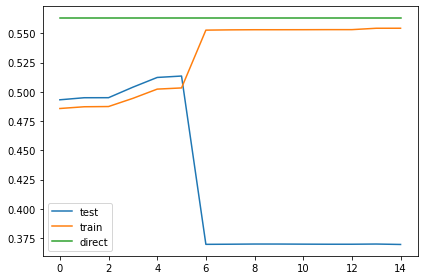

In [ ]:
plt.plot(score,label='test')
plt.plot(score2,label='train')
plt.plot(direct,label='direct')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Other

MSE & R-squared

In [ ]:
# error = []
# for i in range(len(y)):
#   error.append(y[i]-f[i])

In [ ]:
# import numpy as np
# for i in range(15):
#   MSE = np.sum(all_E[i])/3476
#   MSE = float(round(MSE,5))
#   print(str(i+1)+'維PCA的MSE >>> '+str(MSE))

In [ ]:
# from sklearn.metrics import r2_score
# r2 = r2_score(y_test, f)
# print('r2 score >>> ', r2)
# # ar2 = 1 - (1-r.score(X, y_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1)
# # print('a_r2 score >>> ', ar2)

In [ ]:
# from sklearn.metrics import r2_score
# for i in range(15):
#   r2 = r2_score(y_test, predict[i])
#   print(r2)